In [1]:
import os
from dotenv import load_dotenv
import pickle
from datetime import datetime, timedelta
import requests
import pandas as pd


from langchain.tools import tool
from langchain_groq import ChatGroq

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode
from langgraph.errors import GraphRecursionError
from bs4 import BeautifulSoup

In [ ]:
load_dotenv()
os.environ["GROQ_API_KEY"]

In [3]:
with open('../dataset_prep/graph_cleaned.pkl', 'rb') as f:
    G = pickle.load(f)

In [19]:
@tool("get_node_edge_connections")
def get_node_edge_connections_tool(actor: str, recipient: str, date: str):
    """
    Returns up to 10 edges where the actor or recipient is involved before the given date.
    Each result includes source, relation type, target, and timestamp.
    """
    ref_date = pd.to_datetime(date)
    relevant_edges = []

    for u, v, data in G.edges(data=True):
        if actor in [u, v] or recipient in [u, v]:
            ts = pd.to_datetime(G.nodes[u].get("event_date") or G.nodes[v].get("event_date"), errors="coerce")
            if pd.notna(ts) and ts < ref_date:
                relevant_edges.append((u, data.get("relation", "related_to"), v, ts.strftime("%Y-%m-%d")))

    return relevant_edges[:10]


@tool("print_node_attributes")
def print_node_attributes_tool(actor: str, recipient: str, input_date: str):
    """
    Returns metadata for up to 5 event nodes where both actor and recipient are connected.
    Includes event date and a truncated event text field.
    """
    input_date_dt = pd.to_datetime(input_date)
    matching_events = []

    for node in G.nodes:
        event_meta = G.nodes[node]
        event_date = pd.to_datetime(event_meta.get("event_date"), errors="coerce")

        if pd.notna(event_date):
            neighbors = list(G.neighbors(node))
            if actor in neighbors and recipient in neighbors:
                time_diff = abs((event_date - input_date_dt).days)
                matching_events.append((node, time_diff, event_meta))

    matching_events.sort(key=lambda x: x[1])
    top_events = matching_events[:5]

    return {
        event[0]: {
            "event_date": str(event[2].get("event_date")),
            "event_text": (event[2].get("event_text") or "")[:300] + "..."
            if event[2].get("event_text") and len(event[2].get("event_text")) > 300 else event[2].get("event_text", "No text available")
        }
        for event in top_events
    }

@tool("calculate_event_type_frequency")
def calculate_event_type_frequency_tool(actor: str, recipient: str, date: str):
    """
    Counts and returns up to 10 most frequent event types involving the actor or recipient before the given date.
    """
    ref_date = pd.to_datetime(date)
    event_counts = {}

    for u, v, data in G.edges(data=True):
        if actor in [u, v] or recipient in [u, v]:
            ts = pd.to_datetime(G.nodes[u].get("event_date") or G.nodes[v].get("event_date"), errors="coerce")
            if pd.notna(ts) and ts < ref_date:
                etype = G.nodes[u].get("type") or G.nodes[v].get("type")
                if etype:
                    event_counts[etype] = event_counts.get(etype, 0) + 1
    return dict(sorted(event_counts.items(), key=lambda x: x[1], reverse=True)[:10])


@tool("summarize_actor_recipient_history")
def summarize_actor_recipient_history(actor: str, recipient: str):
    """
    Returns a list of up to 10 events connecting the actor and recipient.
    Each includes event ID, date, and a truncated event text for quick summarization.
    """
    summaries = []

    for node in G.nodes:
        meta = G.nodes[node]
        event_date = pd.to_datetime(meta.get("event_date"), errors="coerce")
        neighbors = list(G.neighbors(node))

        if actor in neighbors and recipient in neighbors:
            summaries.append({
                "event_id": node,
                "event_date": str(event_date.date()) if pd.notna(event_date) else "N/A",
                "event_text": (meta.get("event_text") or "")[:300] + "..."
                if meta.get("event_text") and len(meta.get("event_text")) > 300 else meta.get("event_text", "No summary available")
            })

    summaries.sort(key=lambda x: x["event_date"])
    return summaries[:10]


In [20]:
@tool("search_news")
def search_and_extract_news(actor: str, recipient: str, date: str):
    """
    Searches for news articles based on the actor, recipient, and date.
    """
    # Parse the date and create date range 
    target_date = datetime.strptime(date, "%Y-%m-%d")
    from_date = (target_date - timedelta(days=15)).strftime("%Y-%m-%d")
    to_date = (target_date + timedelta(days=5)).strftime("%Y-%m-%d")
    
    if actor=="":
        query = f"{actor}"
    elif recipient=="":
        query = f"{recipient}"
    else:
        query=f"{actor} and {recipient}"
        
    api_key = os.getenv("NEWS_API_KEY")
    url = f"https://newsapi.org/v2/everything?q={query}&from={from_date}&to={to_date}&sortBy=publishedAt&apiKey={api_key}"
    
    response = requests.get(url)
    if response.status_code == 200:
        articles = response.json().get('articles', [])
        results = []
        for article in articles[:3]:  
            article_url = article.get("url")
            if not article_url:
                continue
            content = scrape_content(article_url)
            if content:
                results.append({
                    "title": article.get("title"),
                    "content": content[:500],  
                    "url": article_url
                })
        print(results)
        return {"articles": results} if results else {"message": "No articles found for the specified criteria."}
    else:
        return {"error": f"Error fetching news articles: {response.status_code}"}


def scrape_content(url):
    """
    Scrapes and cleans article content from the given URL.
    """
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        paragraphs = soup.find_all('p')
        content = ' '.join(p.get_text(strip=True) for p in paragraphs)
        content = ' '.join(content.split())
        return content
    except requests.exceptions.RequestException as e:
        print(f"Failed to fetch the URL {url}: {e}")
        return None


In [21]:
tools = [
    get_node_edge_connections_tool,
    print_node_attributes_tool,
    calculate_event_type_frequency_tool,
    summarize_actor_recipient_history,
    search_and_extract_news
]


tool_node = ToolNode(tools)

In [22]:
model = ChatGroq(model="llama-3.3-70b-versatile", temperature=0.2, max_retries=2).bind_tools(tools)

In [ ]:
system_prompt = """
You run in a loop of Thought, Action, PAUSE, Observation.
At the end of the loop, you output an Answer.

Use:
- Thought → to explain your reasoning process
- Action → to invoke a tool (return PAUSE after)
- Observation → to reflect on the output of the tool
- Answer → to conclude with a final decision

---

Task:
You will be given an actor, recipient, and a date.
Your goal is to predict the most likely event type between the given actor and recipient on the given date.

YOUR FINAL ANSWER MUST STRICTLY BE ONE OF THESE OPTIONS:
CONCEDE, COOPERATE, ASSAULT, THREATEN, CONSULT, RETREAT, PROTEST, COERCE, AID, MOBILIZE, REQUEST, SANCTION, ACCUSE

---

🧰 Available Tools:

1. **get_node_edge_connections**  
    Use this to find recent connections involving the actor or recipient before the given date.  
    Use early to build context of prior activity.  
    Format:  
    `get_node_edge_connections: {{"actor": "A", "recipient": "B", "date": "YYYY-MM-DD"}}`

2. **print_node_attributes**  
    Use this to retrieve rich metadata (e.g., event text, date) from events involving both the actor and recipient.  
    Use this to understand interaction context.  
    Format:  
    `print_node_attributes: {{"actor": "A", "recipient": "B", "date": "YYYY-MM-DD"}}`

3. **calculate_event_type_frequency**  
    Use this to check which event types occurred most frequently in the past.  
    Frequency is helpful but should NOT be your only deciding factor.  
    Format:  
    `calculate_event_type_frequency: {{"actor": "A", "recipient": "B", "date": "YYYY-MM-DD"}}`

4. **summarize_actor_recipient_history**  
    Use this to get a chronological list of past events connecting the actor and recipient.  
    Best for trend spotting or escalation/de-escalation patterns.  
    Format:  
    `summarize_actor_recipient_history: {{"actor": "A", "recipient": "B"}}`

5. **search_news**  
    Use this to search real news around the actor and recipient.  
    Use if event_text or historical data is missing or unclear.  
    Format:  
    `search_news: {{"actor": "A", "recipient": "B", "date": "YYYY-MM-DD"}}`

---

🧠 Instructions:

- You may call tools multiple times in any order. Use outputs from one tool to guide the next.
- Try to use more than one tool before concluding.
- You do not need to call all tools, but you must gather enough evidence to make a confident prediction.
- If data is sparse, use reasoning, pattern recognition, or fallback to news.

---

💡 Final Reasoning Format:

Thought: I have gathered sufficient evidence from the tools to make a prediction.  
Thought: Based on the event trends, metadata, and observations, the most likely event type is <<EVENT TYPE>> because <<EXPLAIN REASONING>>.  
Answer: <<EVENT TYPE>>

Now it's your turn:
""".strip()

In [24]:
# Define your maximum iterations
MAX_ITERATIONS = 3

def should_continue(state: MessagesState) -> str:
    """
    Determines the next node based on the presence of a final 'Answer:' message
    or if the maximum iteration count is reached.
    Returns "tools" to continue or END to stop.
    """
    # Check if we've exceeded the maximum iterations.
    current_iteration = state.get("iteration", 0)
    if current_iteration >= MAX_ITERATIONS:
        print("Maximum iteration count reached.")
        return END

    # Check for the final answer.
    for message in state["messages"]:
        if isinstance(message, HumanMessage) and message.content.startswith("Answer:"):
            return END

    return "tools"

def call_model(state: MessagesState) -> MessagesState:
    """
    Calls the model with the current state, increments the iteration counter,
    and returns the updated state.
    """
    try:
        messages = state["messages"]
        response = model.invoke([system_message] + messages)
        # Update the iteration counter.
        current_iteration = state.get("iteration", 0)
        state["iteration"] = current_iteration + 1
        state["messages"] = response
        return state
    except GraphRecursionError:
        print("Recursion error occurred. Please check the graph structure.")
        return state

# Build your workflow using the updated functions.
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", END])
workflow.add_edge("tools", "agent")

app = workflow.compile()


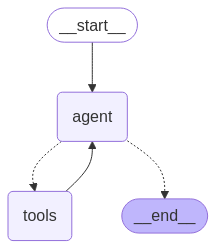

In [10]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [25]:
messages = [
    HumanMessage(content="What is the most likely relation between 'Delhi High Court' and 'Arvind Kejriwal' on 2024-06-29 \
                        Choose from: ACCUSE, THREATEN, COERCE, SANCTION, REQUEST, ASSAULT, RETREAT, CONCEDE, MOBILIZE, PROTEST, CONSULT, AID.")
]

# Initialize the state with both messages and an iteration counter.
initial_state = {"messages": messages, "iteration": 0}

# Stream the output
for chunk in app.stream(initial_state, stream_mode="values"):
    chunk["messages"][-1].pretty_print()


================================ Human Message =================================

What is the most likely relation between 'Delhi High Court' and 'Arvind Kejriwal' on 2024-06-29                         Choose from: ACCUSE, THREATEN, COERCE, SANCTION, REQUEST, ASSAULT, RETREAT, CONCEDE, MOBILIZE, PROTEST, CONSULT, AID.
================================== Ai Message ==================================
Tool Calls:
  search_news (call_besw)
 Call ID: call_besw
  Args:
    actor: Delhi High Court
    recipient: Arvind Kejriwal
    date: 2024-06-29
  get_node_edge_connections (call_1asm)
 Call ID: call_1asm
  Args:
    actor: Delhi High Court
    recipient: Arvind Kejriwal
    date: 2024-06-29
  calculate_event_type_frequency (call_p833)
 Call ID: call_p833
  Args:
    actor: Delhi High Court
    recipient: Arvind Kejriwal
    date: 2024-06-29
  summarize_actor_recipient_history (call_99x4)
 Call ID: call_99x4
  Args:
    actor: Delhi High Court
    recipient: Arvind Kejriwal
  print_node_attr

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.3-70b-versatile` in organization `org_01jezc2cnqe0c8f6s3640rzrr3` service tier `on_demand` on tokens per day (TPD): Limit 100000, Used 101702, Requested 2596. Please try again in 1h1m54.178s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}